# Notebook 1

#### Some remarks

1. I have first tried using `ResNet50` with `imagenet` weights and the original input size of the CIFAR-10 dataset, i.e., `(32,32,3)`. This, however, produced underwelming results, with accuracy on the test set not exceeding 70%. 
2. Then I tried the same strategy with other models trained on `CIFAR-10`: `InceptionV3` and `VGG19` with similar results.
3. Later I decided to resize the `CIFAR-10` inages to the original input size of `ResNet50`, which is `(224,224,3)`, and train it on the resized data. I have acvieved roughly `91.5%` accuracy on the test set after hyperparameter optimization.
4. I also employed the same strategy as in 3. but with `InceptionV3` architecture an slightly worse tetst accuracy. Therefore I only include the resnet results.
5. For comparison I have trained an `sklearn` `KNNClassifier` and `xgboost`s `XGBClassifier` on the `ResNet50` features. The test accuracy I achieved for this methods was `87%` and `85.5%`, respectively.


In [4]:
import numpy as np
import os
import keras
#from keras.applications.inception_v3 import InceptionV3
from keras.models import Model, Input
from keras import models
from keras import layers
import matplotlib.pyplot as plt
plt.rcParams['image.cmap'] = 'gray'

#from keras.datasets import cifar10
from utils import load_dataset


In [2]:
x_train, y_train, x_test, y_test = load_dataset()

#(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_validation = x_train[40000:]
y_validation = y_train[40000:]

x_train = x_train[:40000]
y_train = y_train[:40000]

Loading data: /home/lukasz/Desktop/Machine Learning/Keras/tooploox/cifar-10-batches-py/data_batch_1
Loading data: /home/lukasz/Desktop/Machine Learning/Keras/tooploox/cifar-10-batches-py/data_batch_2
Loading data: /home/lukasz/Desktop/Machine Learning/Keras/tooploox/cifar-10-batches-py/data_batch_3
Loading data: /home/lukasz/Desktop/Machine Learning/Keras/tooploox/cifar-10-batches-py/data_batch_4
Loading data: /home/lukasz/Desktop/Machine Learning/Keras/tooploox/cifar-10-batches-py/data_batch_5
Loading data: /home/lukasz/Desktop/Machine Learning/Keras/tooploox/cifar-10-batches-py/test_batch


In [3]:
x_train.dtype

dtype('int64')

## Explore the CIFAR-10 dataset

In [4]:
cifar_dict = {
    'airplane' : 0,
    'automobile' : 1,
    'bird' : 2,
    'cat' : 3,
    'deer' : 4,
    'dog' : 5,
    'frog' : 6,
    'horse' : 7,
    'ship' : 8,
    'truck' : 9}
cifar_dict_rev = {label: key for key, label in cifar_dict.items()}

In [5]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(40000, 32, 32, 3) (40000,)
(10000, 32, 32, 3) (10000,)


In [6]:
len(np.unique(y_train))

10

In [7]:
num_examples = {}
for j in range(len(np.unique(y_train))):
    num_examples[cifar_dict_rev[j]] = np.sum(y_train.reshape(-1) == j)  

In [8]:
print(num_examples)

{'airplane': 3986, 'automobile': 3986, 'bird': 4048, 'cat': 3984, 'deer': 4003, 'dog': 3975, 'frog': 4020, 'horse': 4023, 'ship': 3997, 'truck': 3978}


In [9]:
def imshow_all_classes():
    image_list = []
    for image_class in range(10):
        class_sublist = []
        for j in range(10):
            sample_image = x_train[np.random.choice(np.where(y_train==image_class)[0])]
            class_sublist.append(sample_image)
        image_list.append(class_sublist)     
    
    fig, axes = plt.subplots(nrows=len(image_list), ncols=10,
                             figsize=(15, 15))
    
    for row in range(10):
        for col in range(10):
            axes[row, col].xaxis.set_major_locator(plt.NullLocator())
            axes[row, col].yaxis.set_major_locator(plt.NullLocator())
            axes[row, col].imshow(image_list[row][col])
            plt.axis('off')
        

### Plot ten randomly chosen images from each category

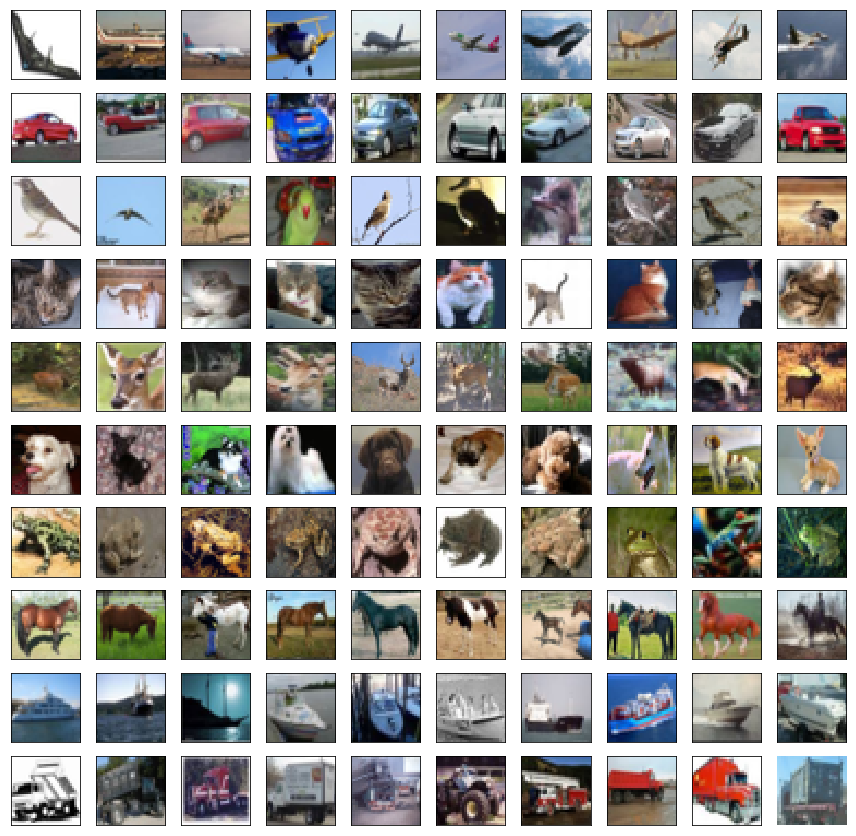

In [10]:
imshow_all_classes()

## 1. Train a shallow model

For feature extraction in the shallow model we will use, as suggested, HoG algorithm. 

### 1.1 Feature extraction

In [11]:
from skimage.feature import hog
from skimage import data, exposure

def hog_features_batch(batch):
    hog_list = [hog(image, orientations=8, pixels_per_cell=(16, 16),
                   cells_per_block=(1, 1), multichannel=True) for image in batch]
    return np.array(hog_list)

In [12]:
%%time
hog_train = hog_features_batch(x_train)
hog_validation = hog_features_batch(x_validation)
hog_test = hog_features_batch(x_test)

/home/lukasz/.local/lib/python3.6/site-packages/skimage/feature/_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)


CPU times: user 30 s, sys: 9.14 ms, total: 30 s
Wall time: 30.1 s


### 1.2 Training a shallow neaural network on top of the extracted features

In [13]:
from keras.models import Sequential
from keras.utils import to_categorical

model = Sequential()
model.add(layers.Dense(500, input_shape=(32,), activation='relu'))
model.add(layers.Dense(500, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

Instructions for updating:
Colocations handled automatically by placer.


In [14]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 500)               16500     
_________________________________________________________________
dense_2 (Dense)              (None, 500)               250500    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5010      
Total params: 272,010
Trainable params: 272,010
Non-trainable params: 0
_________________________________________________________________


In [15]:
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', 
                                           patience=3, 
                                           verbose=0, 
                                           mode='auto', 
                                           baseline=None, 
                                           restore_best_weights=True)]

In [16]:
history = model.fit(hog_train, to_categorical(y_train),
                   epochs=50, 
                   batch_size=64,
                   callbacks=callbacks,
                   validation_data=(hog_validation, to_categorical(y_validation)))

Instructions for updating:
Use tf.cast instead.
Train on 40000 samples, validate on 10000 samples
Epoch 1/50
40000/40000 [==============================] - 5s 125us/step - loss: 1.7502 - acc: 0.3730 - val_loss: 1.6447 - val_acc: 0.4121
Epoch 2/50
40000/40000 [==============================] - 5s 127us/step - loss: 1.6089 - acc: 0.4282 - val_loss: 1.5796 - val_acc: 0.4395
Epoch 3/50
40000/40000 [==============================] - 5s 131us/step - loss: 1.5555 - acc: 0.4476 - val_loss: 1.5382 - val_acc: 0.4508
Epoch 4/50
40000/40000 [==============================] - 4s 112us/step - loss: 1.5229 - acc: 0.4605 - val_loss: 1.5173 - val_acc: 0.4594
Epoch 5/50
40000/40000 [==============================] - 4s 110us/step - loss: 1.4987 - acc: 0.4654 - val_loss: 1.4995 - val_acc: 0.4648
Epoch 6/50
40000/40000 [==============================] - 4s 112us/step - loss: 1.4739 - acc: 0.4742 - val_loss: 1.4981 - val_acc: 0.4721
Epoch 7/50
40000/40000 [==============================] - 4s 112us/step - 

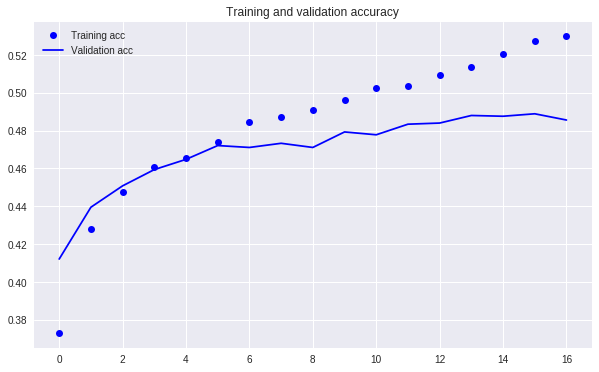

In [17]:
def plot_training_history(history):
    plt.style.use('seaborn-notebook')
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))
    plt.style.use('seaborn')
    fig, axis = plt.subplots(figsize=(10,6))
    axis.plot(epochs, acc, 'bo', label='Training acc')
    axis.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend(loc='best')
    plt.show()
    
plot_training_history(history)

The networks begins overfitting the data quite early on.

In [18]:
optimal_number_of_epochs = len(history.history['acc'])
print(optimal_number_of_epochs)

17


Fit the model on the train and validation steps for the number of epochs sugested by early stopping. However, we must reset the model weights first.

In [19]:
def reset_weights(model):
    import keras.backend as K
    session = K.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)
            
reset_weights(model)

In [20]:
history_test = model.fit(np.concatenate([hog_train, hog_validation], axis=0),  
                    np.concatenate([to_categorical(y_train), to_categorical(y_validation)], axis=0),
                   epochs=optimal_number_of_epochs, 
                   batch_size=64)

Epoch 1/17
50000/50000 [==============================] - 5s 108us/step - loss: 1.7171 - acc: 0.3778
Epoch 2/17
50000/50000 [==============================] - 6s 116us/step - loss: 1.5850 - acc: 0.4365
Epoch 3/17
50000/50000 [==============================] - 6s 122us/step - loss: 1.5333 - acc: 0.4558
Epoch 4/17
50000/50000 [==============================] - 6s 113us/step - loss: 1.5041 - acc: 0.4674
Epoch 5/17
50000/50000 [==============================] - 5s 106us/step - loss: 1.4791 - acc: 0.4736
Epoch 6/17
50000/50000 [==============================] - 5s 108us/step - loss: 1.4598 - acc: 0.4804
Epoch 7/17
50000/50000 [==============================] - 5s 107us/step - loss: 1.4413 - acc: 0.4885
Epoch 8/17
50000/50000 [==============================] - 5s 107us/step - loss: 1.4258 - acc: 0.4954
Epoch 9/17
50000/50000 [==============================] - 5s 108us/step - loss: 1.4133 - acc: 0.4972
Epoch 10/17
50000/50000 [==============================] - 6s 117us/step - loss: 1.3973 - a

In [21]:
shallow_prediction = np.argmax(model.predict(hog_test), axis=1)
print('Accuracy of the shallow MLP classifier: ', np.mean(shallow_prediction==y_test.reshape(-1)))

Accuracy of the shallow MLP classifier:  0.4905


So the accuracy in the shallow model is roughly `49%`

Clear memory for the future use.

In [22]:
del([model, hog_train, hog_validation, hog_test])

## 2. Extract features using a pre-trained CNN

### 2.1 ResNet50

We use `ResNet50` pretrained on 'imagenet' to do feature extraction.

In [3]:
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input as resnet_preprocessor
resnet_input_shape=(224,224,3)
batch_size=50


We do some data preprocessing specific to the resnet architecture.

In [4]:
x_train = resnet_preprocessor(x_train)
x_validation = resnet_preprocessor(x_validation)
x_test = resnet_preprocessor(x_test)

The `ResNet50` model in Keras has been pretrained with images of the size `(224, 224, 3)` so to make the most of the expresiveness of the neural network we rescale images so that they are of this exact shape.

In [5]:
from skimage.transform import resize
def resize_image(x, target_size):
    """ The function resizes an image 'x' to the target size 'target_size'"""
    return resize(x, target_size, anti_aliasing=False)

def resize_image_batch(x, target_size):
    result = []
    for j in range(len(x)):
        result.append(resize_image(x[j], target_size))
    return np.array(result)

In [6]:
from sklearn.utils import shuffle as sklearn_shuffle 
def datagen(X,Y, batch_size=batch_size, shuffle=False, target_size=resnet_input_shape):
    if shuffle:
        X, Y = sklearn_shuffle(X, Y)
    # loop endlessly
    counter = 0
    while True:
        Xbatch = X[counter:counter+batch_size]
        Ybatch = Y[counter:counter+batch_size]
        counter += batch_size
        if counter > X.shape[0]:
            counter = 0
            # shuffle again after every epoch
            if shuffle:
                X, Y = sklearn_shuffle(X,Y)
        yield (resize_image_batch(Xbatch, target_size), resize_image_batch(Ybatch, target_size))
    

Now we can extract features using `ResNet50`. This takes some time on mu laptop (roughly 25 minutes), so I save the computed features to the disk. 

In [7]:
%%time
base_model = ResNet50(include_top=False, input_shape = resnet_input_shape, weights='imagenet', pooling='max')
codes_train = base_model.predict_generator(
    datagen(x_train, y_train),
    steps=x_train.shape[0]/batch_size, verbose=1)
codes_validation = base_model.predict_generator(
    datagen(x_validation, y_validation),
    steps=x_validation.shape[0]/batch_size, verbose=1)
codes_test = base_model.predict_generator(
    datagen(x_test, y_test),
    steps=x_test.shape[0]/batch_size, verbose=1)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


/home/lukasz/.local/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/lukasz/.local/lib/python3.6/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))


 14/800 [..............................] - ETA: 2:23:41

KeyboardInterrupt: 

In [13]:
%%time
import os
import h5py
current_path = os.getcwd()
filename = 'ResNet50_CIFAR-10_features.h5'
#filename = 'VGG19_CIFAR-10_features.h5'

if not os.path.isfile(filename):
    
    hf = h5py.File(filename, 'w')
    hf.create_dataset('codes_train', data=codes_train)
    hf.create_dataset('codes_validation', data=codes_validation)
    hf.create_dataset('codes_test', data=codes_test)
    hf.close()

hf = h5py.File(filename, 'r')
codes_train = np.array(hf.get('codes_train'))
codes_validation = np.array(hf.get('codes_validation'))
codes_test = np.array(hf.get('codes_test'))
hf.close()

CPU times: user 84.2 ms, sys: 466 ms, total: 550 ms
Wall time: 988 ms


In [5]:
print(codes_train.shape)
print(codes_validation.shape)
print(codes_test.shape)

(40000, 2048)
(10000, 2048)
(10000, 2048)


## 3. Visualize the CNN codes

In [3]:
del([x_train, x_validation, x_test])

Below we choose the number of sample we want to visualize. 

In [27]:
examples = codes_train[:40000]
examples_labels = y_train[:40000]

### t-SNE visualization

In [28]:
from sklearn.manifold import TSNE
examples_tsne = examples.reshape(examples.shape[0], -1)


(40000, 2048)

Running the cell below takes some time. The algorithm in `sklearn` neither uses my GPU card, nor is it run in parallel on CPU cores. It took 2h on the whole codes_train dataset. Therefore I include the picture in the main directory.

In [ ]:
import matplotlib.image as mpimg
img=mpimg.imread('t-SNE_embedding.png')
imgplot = plt.imshow(img)
plt.show()

In [29]:
%%time
tsne = TSNE(n_components=2, perplexity=20.0)
tsne_embedding = tsne.fit_transform(examples_tsne)

CPU times: user 2h 8min 27s, sys: 1.59 s, total: 2h 8min 28s
Wall time: 2h 8min 27s


### Plot the embedding

In [55]:
def plot_2d_embedding(tsne_embedding, examples_labels):
    plt.style.use('seaborn-dark')
    data = []
    np.random.seed(24)
    colors = ['red', 'orange', 'green', 'yellow', 'plum', 
             'navy', 'salmon', 'skyblue', 'darkred', 'aqua']
    group_names = []
    for j in np.unique(examples_labels):
        
        data.append(tsne_embedding[examples_labels.reshape(-1)==j])
        group_names.append(cifar_dict_rev[j])
    fig, axis = plt.subplots(figsize=(10,10))
    for data, group_name, color in zip (data, group_names, colors):
        x, y = data[:,0], data[:,1]
        axis.scatter(x, y, alpha=0.8, edgecolors='none', s=30, label=group_name, c=color)
    plt.title('t-SNE embedding in 2 dimensions')
    plt.legend(loc='best')
    plt.savefig('t-SNE_embedding.png')
    plt.show()

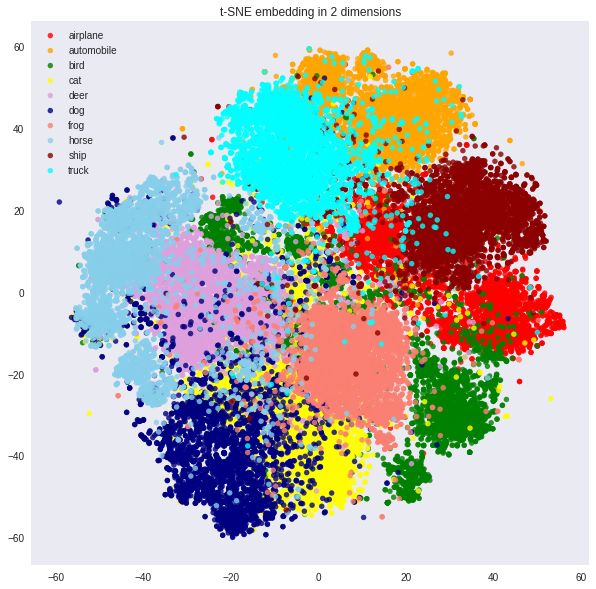

In [56]:
plot_2d_embedding(tsne_embedding, examples_labels)

## 4 Train an SVM on top of extracted cnn codes

In [7]:
mean_train = codes_train.mean(axis=0)
mean_validation = codes_validation.mean(axis=0)
mean_test = codes_test.mean(axis=0)

automobile


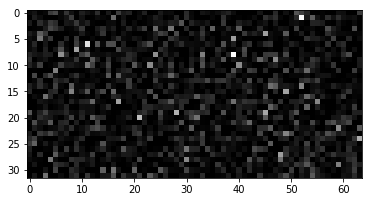

In [11]:
example = 134
print(cifar_dict_rev[int(y_train[example])])
plt.imshow((codes_train[example]).reshape(32, -1))
plt.show()

### 4.1 Using a linear kernel

I need to clear some memory first.

In [3]:
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from scipy.stats import uniform
from sklearn.svm import LinearSVC
import xgboost as xgb
n_iter_search = 1

In [7]:
def LinearSVC_search(train_data, validation_data, number_of_searches=4):
    """ Both train_data and validation_data are tuples of the form (features, labels)"""
    
    param_grid = {
                  'C': [10,1, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001], 
                  'multi_class': ['crammer_singer', 'ovr'] } 
    best_params = {}
    best_valid_accuracy = 0.
    best_valid_labels = None
    best_model= None
    for step in range(number_of_searches):
        params = {}
        for parameter in param_grid:
            params[parameter] = np.random.choice(param_grid[parameter])
        print('Fitting with params: \n:', params)
        
        svm = LinearSVC(**params)
        svm.fit(train_data[0], train_data[1].reshape(-1))
        y_pred_vaild = svm.predict(validation_data[0])
        valid_accuracy = accuracy_score(y_pred_vaild.reshape(-1), validation_data[1].reshape(-1))
        print("Accuracy on validation set: ", valid_accuracy)
        if valid_accuracy > best_valid_accuracy:
            best_params = params
            best_valid_accuracy = valid_accuracy
            best_valid_labels = y_pred_vaild
            best_model = svm
    return best_params, best_valid_accuracy, best_valid_labels, best_model

In [8]:
def xgboost_search(train_data, validation_data, number_of_searches=1):
    """ Both train_data and validation_data are tuples of the form (features, labels)"""
    
    
    param_grid = {'learning_rate': [1, 0.1, 0.01], 
                  'max_depth': [4, 8, 16],
                  'n_estimators': [10, 20, 40, 100]}
    
    best_valid_labels = None
    best_params = {}
    best_valid_accuracy = 0.
    best_model= None
    for step in range(number_of_searches):
        params = {}
        for parameter in param_grid:
            params[parameter] = np.random.choice(param_grid[parameter])
        print('Fitting with params: \n', params)
        
        classifier = xgb.XGBClassifier(**params)
        classifier.fit(train_data[0], train_data[1].reshape(-1))
        y_pred_vaild = classifier.predict(validation_data[0])
        valid_accuracy = accuracy_score(y_pred_vaild.reshape(-1), validation_data[1].reshape(-1))
        print("Accuracy on validation set: ", valid_accuracy)
        if valid_accuracy > best_valid_accuracy:
            best_params = params
            best_valid_accuracy = valid_accuracy
            best_valid_labels = y_pred_vaild
            best_model = classifier
    return best_params, best_valid_accuracy, best_valid_labels, best_model

In [9]:
from sklearn.neighbors import KNeighborsClassifier

def KNN_search(train_data, validation_data, number_of_searches=1):
    """ Both train_data and validation_data are tuples of the form (features, labels)"""
    
    param_grid = {'n_neighbors': [2, 5, 10, 20]} 
              
    best_params = {}
    best_valid_accuracy = 0.
    best_valid_labels = None
    best_model = None
    for step in range(number_of_searches):
        params = {}
        for parameter in param_grid:
            params[parameter] = np.random.choice(param_grid[parameter])
        print('Fitting with params: \n:', params)
        
        knn = KNeighborsClassifier(**params)
        knn.fit(train_data[0], train_data[1])
        y_pred_vaild = knn.predict(validation_data[0])
        valid_accuracy = accuracy_score(y_pred_vaild.reshape(-1), validation_data[1].reshape(-1))
        print("Accuracy on validation set: ", valid_accuracy)
        if valid_accuracy > best_valid_accuracy:
            best_params = params
            best_valid_accuracy = valid_accuracy
            best_valid_labels = y_pred_vaild
            best_model = knn
    return best_params, best_valid_accuracy, best_valid_labels, best_model

We create a folder to save best models

In [5]:
from joblib import dump, load
import os

dir_name = 'sklearn_saved_models'
if not os.path.isdir(dir_name):
    os.mkdir(dir_name)

### Searching for good hyperparameters for LinearSVC

In [21]:
%%time
svc_res = LinearSVC_search((codes_train, y_train), (codes_validation, y_validation), number_of_searches=25)

Fitting with params: 
: {'C': 1e-06, 'multi_class': 'ovr'}
Accuracy on validation set:  0.9029
CPU times: user 10.5 s, sys: 92.7 ms, total: 10.6 s
Wall time: 10.4 s


Take the best models and train it on the train and validation sets combined. The most important parameter here is `C` which determines how large margins do we want have betweend points with different labels. 'Small' `C` means large margins and can be thought of as a way to prevent overfitting. 

The random searches I have run indicate that the optimal value of `C` is abaout $0.00001$, which is not surprising given the dimensionality (`2048`) of the feature vectors.

Train the model with optimal weights on the train and validation datasets.

In [11]:
if os.path.isfile(dir_name+'/svc.joblib'):
    best_svc_model = load(dir_name+'/svc.joblib') 
else:
    best_svc_model_params = svc_res[0]
    best_svc_model = LinearSVC(**best_svc_model_params)
    best_svc_model.fit(np.concatenate([codes_train, codes_validation], axis=0), 
                    np.concatenate([y_train, y_validation], axis=0))
    dump(best_svc_model, dir_name+'/svc.joblib')

#### Get the accuracy on the test set

In [14]:
prediction_test_svc = best_svc_model.predict(codes_test)
svc_acc = accuracy_score(prediction_test_svc, y_test)
print('Accuracy on the test set equals: ', accuracy_score(prediction_test_svc, y_test))

Accuracy on the test set equals:  0.916


### Searching for good hyperparameters for XGBoost

I have traine `XGBClassifier` only on `25%` feature samples from `codes_train`. On the whole dataset the algorithm was incredibly slow.

In [13]:
%%time
xgb_res = xgboost_search((codes_train[:10000], y_train[:10000]), (codes_validation[:1000], y_validation[:1000]))

Fitting with params: 
 {'learning_rate': 1, 'max_depth': 16, 'n_estimators': 500}
Accuracy on validation set:  0.826
Fitting with params: 
 {'learning_rate': 1, 'max_depth': 16, 'n_estimators': 100}


KeyboardInterrupt: 

Running the search I have found out that the best parameters are `learning_rate=1.0`, `max_depth=4` and `n_estimators=100`.

In [15]:
if os.path.isfile(dir_name+'/xgboost.joblib'):
    best_xgb_model = load(dir_name+'/xgboost.joblib') 
else:
    best_xgb_model_params = xgb_res[0]
    best_xgb_model = XGBClassifier(**best_xgb_model_params)
    best_xgb_model.fit(np.concatenate([codes_train, codes_validation], axis=0), 
                    np.concatenate([y_train, y_validation], axis=0))
    dump(best_xgb_model, os.path.join(dir_name, 'xgboost.joblib'))

#### Get the accuracy on the test set

In [16]:
prediction_test_xgb = best_xgb_model.predict(codes_test)
xgb_acc = accuracy_score(prediction_test_xgb, y_test)
print('Accuracy on the test set equals: ', accuracy_score(prediction_test_xgb, y_test))

Accuracy on the test set equals:  0.8568


We get `85.5%` accuracy. So the accuracy is worse than in the case of `SVM` model.

### Searching for good hyperparameters for KNNClassifier

In [15]:
%%time
knn_res = KNN_search((codes_train[:10000], y_train[:10000]), (codes_validation, y_validation))

Fitting with params: 
: {'n_neighbors': 3}
Accuracy on validation set:  0.8679
CPU times: user 30min 15s, sys: 496 ms, total: 30min 16s
Wall time: 30min 18s


In [11]:
if os.path.isfile(dir_name+'/knn.joblib'):
    best_knn_model = load(dir_name+'/knn.joblib') 
else:
    best_knn_model_params = knn_res[0]
    best_knn_model = KNeighborsClassifier(**best_knn_model_params)
    best_knn_model.fit(np.concatenate([codes_train, codes_validation], axis=0), 
                    np.concatenate([y_train, y_validation], axis=0))
    dump(best_knn_model, os.path.join(dir_name, 'knn.joblib'))

Running the cell below may take some time so I include the precomputed array so that it can be loaded. 

In [8]:
if os.path.isfile(dir_name + '/knn_predictions.npy'):
    prediction_test_knn = np.load(dir_name + '/knn_predictions.npy')
else:
    prediction_test_knn = best_knn_model.predict(codes_test)

In [10]:
knn_acc = accuracy_score(prediction_test_knn, y_test)
print('Accuracy on the test set equals: ', accuracy_score(prediction_test_knn, y_test))

Accuracy on the test set equals:  0.8709


The achieved accuracy is about `87%`, which better than for `XGBClassifier`, but still much worse than `SVM`.

In [33]:
delete(best_knn_model)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='uniform')

### Ensemble 

In [17]:
accuracies = [svc_acc, xgb_acc, knn_acc]
predictions = np.stack([prediction_test_svc, prediction_test_xgb, prediction_test_knn], axis=1)

In [19]:
print(accuracies)

[0.916, 0.8568, 0.8709]


#### Let us see how highly corellated are the predictions 

In [21]:
corr = np.corrcoef(predictions, rowvar=False)
corr

array([[1.        , 0.87703338, 0.84866104],
       [0.87703338, 1.        , 0.81137833],
       [0.84866104, 0.81137833, 1.        ]])

In [39]:
def ensemble_vote(predictions, accuracies):
    weights = [1/(1-accuracy) for accuracy in accuracies]
    
    sum_weights = sum(weights)
    weights = [weight/sum_weights for weight in weights]
    weights = np.expand_dims(np.array(weights), axis=1)
    
    res = np.zeros((predictions.shape[0], 10))
    for j in range(10):
        res[:, j] = np.matmul((predictions==j).astype('int'), weights).sum(axis=1)
    return np.argmax(res, axis=1)

ensemble_prediction = ensemble_vote(predictions, accuracies)

In [40]:
print(accuracy_score(ensemble_prediction, y_test))

0.9114


It seems that the ensemble I constructed does not work any better than `SVM`. 